In [1]:
# Open river_side.jpeg
from skimage import io
import matplotlib.pyplot as plt
import pywt
import numpy as np
from icecream import ic

# Imported helper funcs
def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]
    
def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    ic(LH.shape, HL.shape, HH.shape)
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))

def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs

def dwt2(im):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=4)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim

def idwt2(Wim):
    coeffs = img2coeffs(Wim, levels=4)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')



ic| LH.shape: (50, 75), HL.shape: (50, 75), HH.shape: (50, 75)
ic| LH.shape: (100, 150), HL.shape: (100, 150), HH.shape: (100, 150)
ic| LH.shape: (200, 300), HL.shape: (200, 300), HH.shape: (200, 300)
ic| LH.shape: (400, 600), HL.shape: (400, 600), HH.shape: (400, 600)


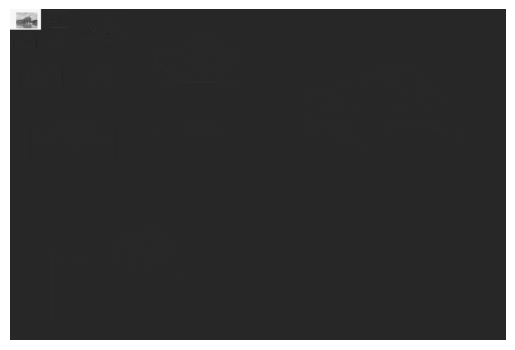

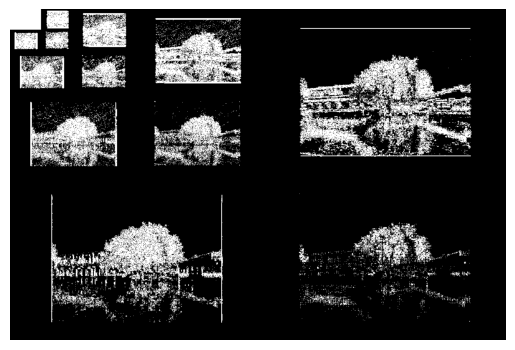

In [3]:
# Read the image.
img = io.imread('data/river_side.jpeg')

# Convert RGB to gray scale.
img_gray = np.mean(img, axis=2)



# Apply DWT using the Daubechies wavelet 4 and 4 levels of decomposition.
Wim = dwt2(img_gray)

# Display the wavelet coefficients.
plt.figure()
plt.imshow(Wim, cmap='gray')
plt.axis('off')
plt.show()

# Threshold to view the largest 15% of the coefficients.
Wim_abs = np.abs(Wim)
Wim_threshold = np.abs(Wim) > np.percentile(Wim_abs, 85)

plt.figure()
plt.imshow(Wim_threshold, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Apply inverse DWT to reconstruct the image.
img_reconstructed = idwt2(Wim)
plt.imshow(img_reconstructed, cmap='gray')

In [ ]:
# Take a difference between the original and reconstructed images.
diff = img_gray - img_reconstructed

# Display the difference.
plt.figure()
plt.imshow(diff, cmap='gray')
plt.colorbar()

plt.title('Mean squared error: %.2f' % np.mean(diff**2))
plt.axis('off')
plt.show()

In [ ]:
# Retain a varying percentage of the largest coefficients.
proportions = [0.001, 0.02, 0.05, 0.1, 0.2]

# Initialize the figure.
plt.figure()

# Loop over the proportions.
for i, proportion in enumerate(proportions):
    # Copy the wavelet coefficients.
    Wim_copy = Wim.copy()
    Wim_abs = np.abs(Wim_copy)

    # Threshold the wavelet coefficients.
    Wim_copy[Wim_abs < np.percentile(Wim_abs, 100*(1-proportion))] = 0
    
    # Reconstruct the image using the thresholded coefficients.
    img_reconstructed = idwt2(Wim_copy)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Show the reconstruction
    ax[0].imshow(img_reconstructed, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(f'Proportion: {proportion}')
    
    # Plot the difference.
    diff = img_gray - img_reconstructed
    ax[1].imshow(diff, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title(f'Difference: {np.round(np.mean(np.abs(diff)), 2)}')
    
    plt.show()

    
    